In [49]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots, cm
from sklearn.metrics import RocCurveDisplay
import sklearn.model_selection as skm
from sklearn.svm import SVC
from ISLP import load_data, confusion_table
from ISLP.svm import plot as plot_svm


In [50]:
roc_curve = RocCurveDisplay.from_estimator

## 9.6 Lab: Support Vector Machines

In this lab, we use the `sklearn.svm` library to demonstrate the support vector classifer and the support vector machine.

### 9.6.1 Support Vector Classifier

We fit the support vector classifier for a given value of parameter `C`, the cost of a violation to the margin. Where `C` is small, the margins will be wide and many support vectors will be on or violate the margin. Where `C` is lage, the margins will be narrow and there will be few support vectors on or violating the margin.

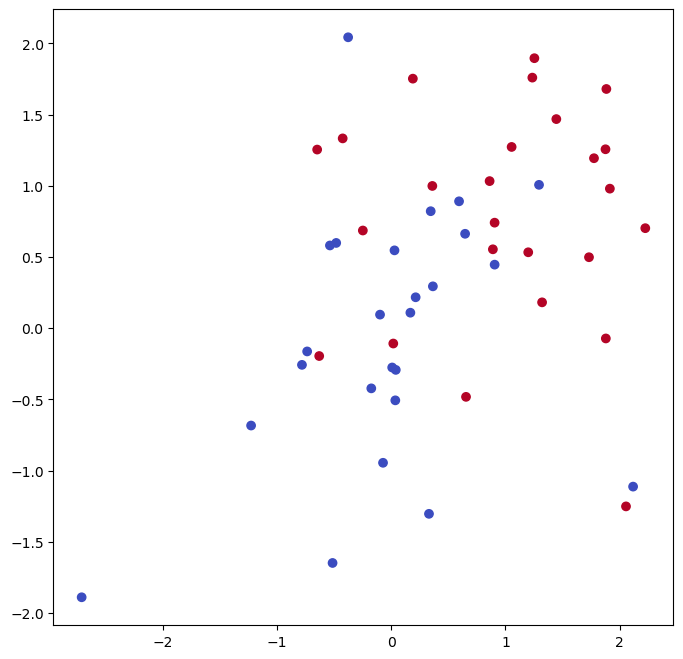

In [51]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1
fig, ax = subplots(figsize=(8,8))
ax.scatter(
    X[:,0],
    X[:,1],
    c=y,
    cmap=cm.coolwarm
);

Note that the two classes in this randomly generated data are not linearly separable. 

We now fit the classifier:

In [52]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)

SVC(C=10, kernel='linear')

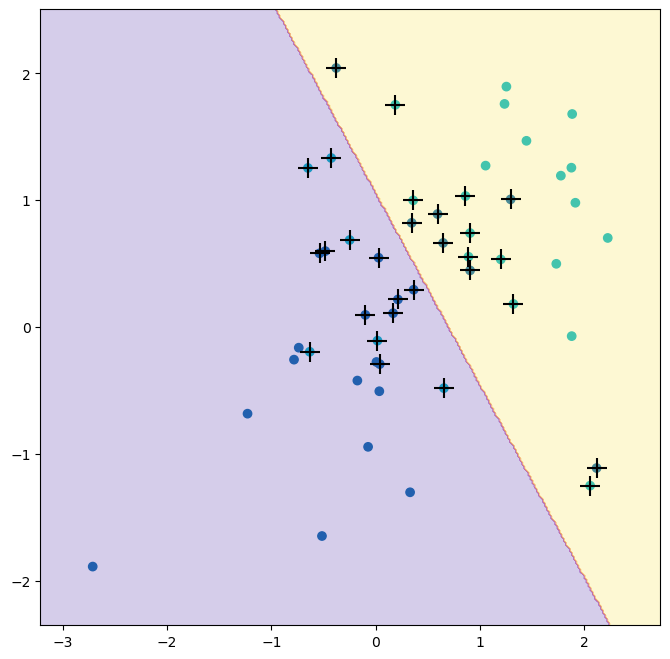

In [53]:
fig, ax = subplots(figsize=(8, 8))
plot_svm(X, y, svm_linear, ax=ax)

What is we use a smaller cost parameter (`C` value)?

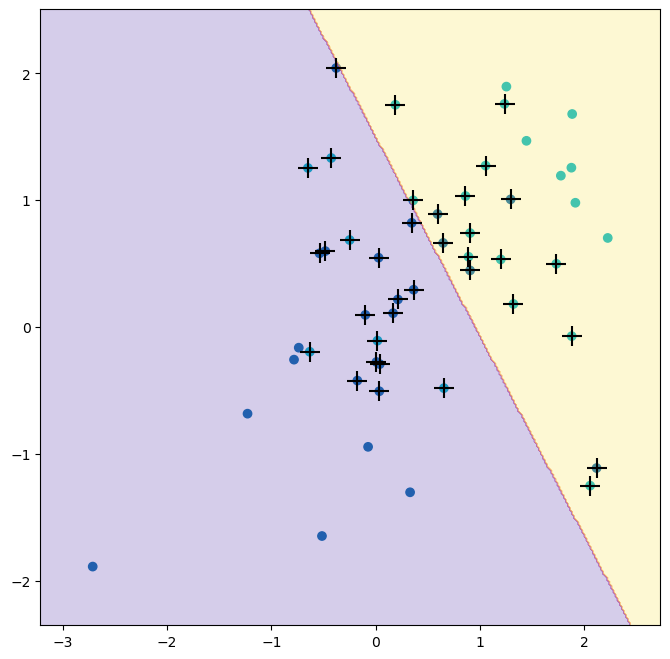

In [54]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)
fig, ax = subplots(figsize=(8, 8))
plot_svm(
    X,
    y,
    svm_linear_small,
    ax=ax
)

With a smaller value of the cost parameter, we obtain a larger number of support vectors because the margin is wider.

Since the SVM is an estimator in `sklearn`, we can tune it:

In [55]:
kfold = skm.KFold(
    5,
    random_state=0,
    shuffle=True
)

grid = skm.GridSearchCV(
    svm_linear,
    {'C': [0.001, 0.01, 0.1, 0.1, 1, 5, 10, 100]},
    refit=True,
    cv=kfold,
    scoring='accuracy'
)

grid.fit(X, y)
grid.best_params_

{'C': 1}

We can see that `C=1` is the lowest `C` value with the maximum accuracy:

In [56]:
grid.cv_results_[('mean_test_score')]

array([0.46, 0.46, 0.72, 0.72, 0.74, 0.74, 0.74, 0.74])

We generate a test data set:

In [57]:
X_test = rng.standard_normal((20, 2))
y_test = np.array([-1]*10+[1]*10)
X_test[y_test==1] += 1

We predict the class labels of these test observations, using the best model selected by cross-validaton to make the predictions:

In [58]:
best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)
confusion_table(y_test_hat, y_test)

Truth,-1,1
Predicted,,
-1,8,4
1,2,6


With `C=1`, 70% of the test observations are correctly classified.

What happens when we use `C=0.001`?

In [59]:
svm_ = SVC(
    C=0.001,
    kernel='linear'
).fit(X, y)

y_test_hat = svm_.predict(X_test)
confusion_table(y_test_hat, y_test)

Truth,-1,1
Predicted,,
-1,2,0
1,8,10


With `C=0.001`, only 60% of test observations are correctly classified.

Now we consider the situation where the two classes are linearly separable.

We first further separate the two classes in the simulated data so that they are separable:

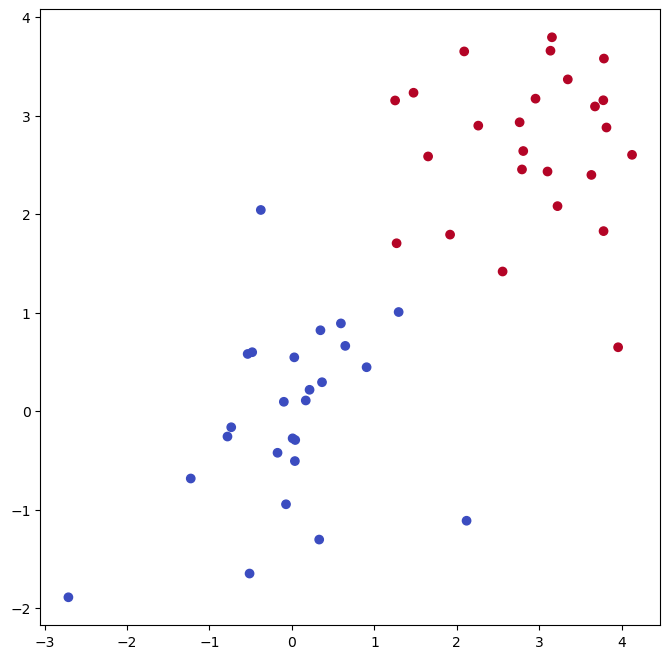

In [60]:
X[y==1] += 1.9
fig, ax = subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.coolwarm);

Using a very large value of `C=1e5` ensures that no observations are misclassified:

In [61]:
svm_ = SVC(C=1e5, kernel='linear').fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


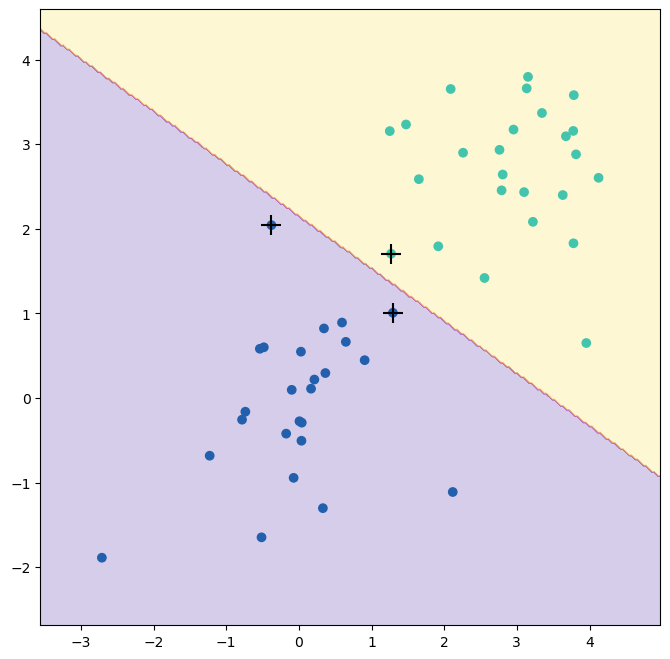

In [62]:
fig, ax = subplots(figsize=(8, 8))
plot_svm(
    X,
    y,
    svm_,
    ax=ax
)

Using `C=0.1`, we don't misclassify any training observations but we do obtain a much wider margin and use 12 support vectors.

In [63]:
svm_ = SVC(C=0.1, kernel='linear').fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


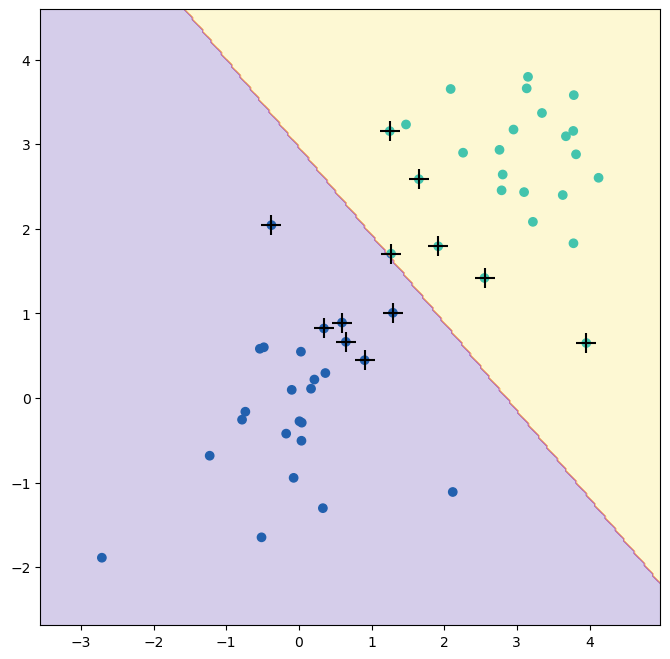

In [64]:
fig, ax = subplots(figsize=(8, 8))
plot_svm(
    X,
    y,
    svm_,
    ax=ax
)

### 9.6.2 Support Vector Machine

To fit an SVM using a non-linear kernel, we use a different value for the `kernel` parameter. We can use the `degree` and `gamma` parameters for the `poly` and `radial` kernels respectively.

We first generate some data with a non-linear class boundary:

In [65]:
X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

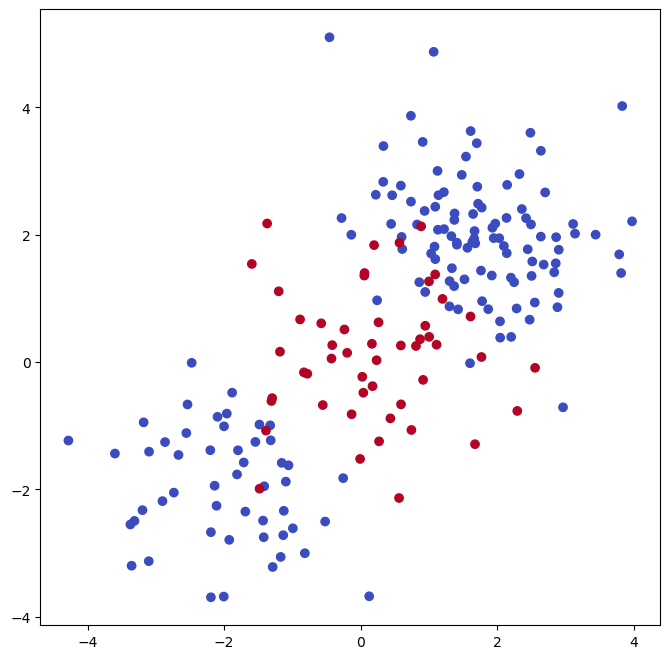

In [66]:
fig, ax = subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.coolwarm);

We split the data randomly into train and test groups, then fit with the `SVC()` estimator using a radial kernel, `gamma=1`:

In [67]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, y, test_size=0.5, random_state=0)
svm_rbf = SVC(kernel='rbf', gamma=1, C=1)
svm_rbf.fit(X_train, y_train)

SVC(C=1, gamma=1)

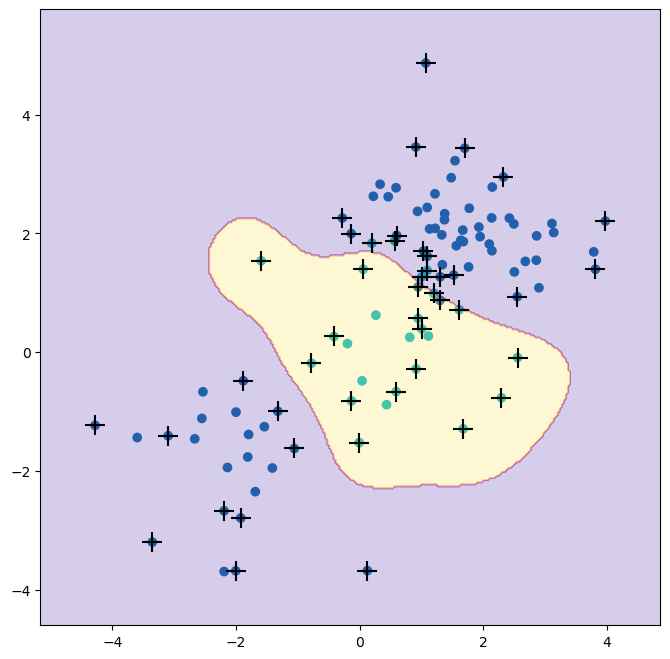

In [68]:
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_train, y_train, svm_rbf, ax=ax)

If we increase `C`, we make the margins smaller and reduce the number of training errors, but thsi comes at the cost of  more irregular, overfitted decision boundary:

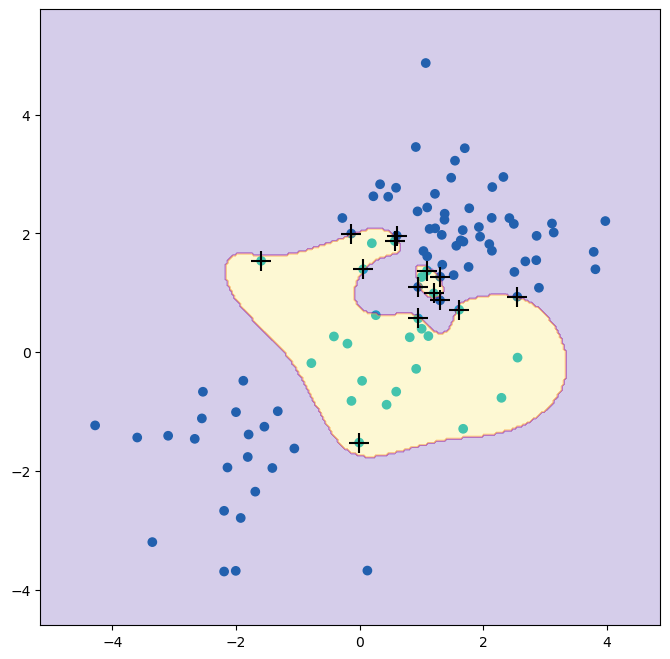

In [70]:
svm_rbf = SVC(kernel='rbf', gamma=1, C=1e5)
svm_rbf.fit(X_train, y_train)
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_train, y_train, svm_rbf, ax=ax)

We perform cross-validatoin using `skm.GridSearchCV()` to select the best choice of `gamma` and `C` for an SVM using a radial kernel:

In [73]:
kfold = skm.KFold(5, random_state=0, shuffle=True)
grid = skm.GridSearchCV(
    svm_rbf,
    {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [0.5, 1, 2, 3, 4]
    },
    refit=True,
    cv=kfold,
    scoring='accuracy'
)

grid.fit(X_train, y_train)
grid.best_params_


{'C': 1, 'gamma': 0.5}

In [74]:
grid.cv_results_[('mean_test_score')]

array([0.76, 0.75, 0.75, 0.75, 0.75, 0.91, 0.91, 0.87, 0.86, 0.85, 0.88,
       0.88, 0.88, 0.86, 0.84, 0.89, 0.89, 0.87, 0.85, 0.85, 0.91, 0.88,
       0.86, 0.85, 0.85])

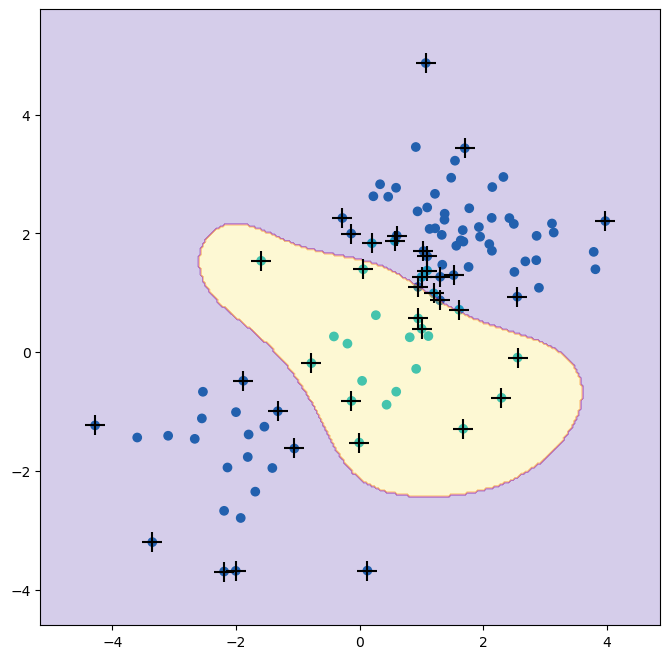

In [75]:
best_svm = grid.best_estimator_
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_train, y_train, best_svm, ax=ax);

In [78]:
y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test, y_test)

Truth,1,2
Predicted,,
1,69,6
2,6,19


With these parameters, 88% of observations are correcly classified by the SVM.

### 9.6.3 ROC Curves

By considering a range of classification thresholds other than just zero, we can produce a ROC curve using he `ROCCurveDisplay.from_estimator()` function.

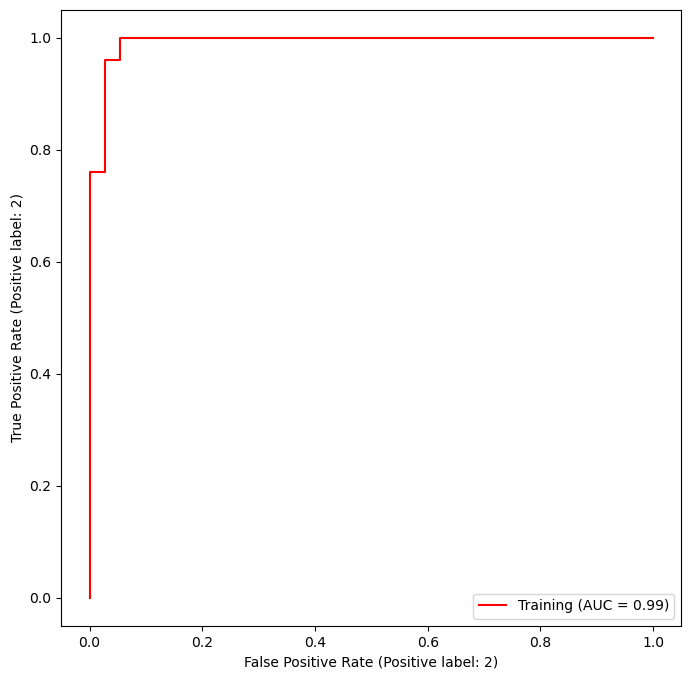

In [79]:
fig, ax = subplots(figsize=(8, 8))
roc_curve(
    best_svm,
    X_train,
    y_train,
    name='Training',
    color='r',
    ax=ax
);

By increasing `gamma`, we can produce a more flexible fit and generate further improvements in training accuracy by making the boundary more non-linear:

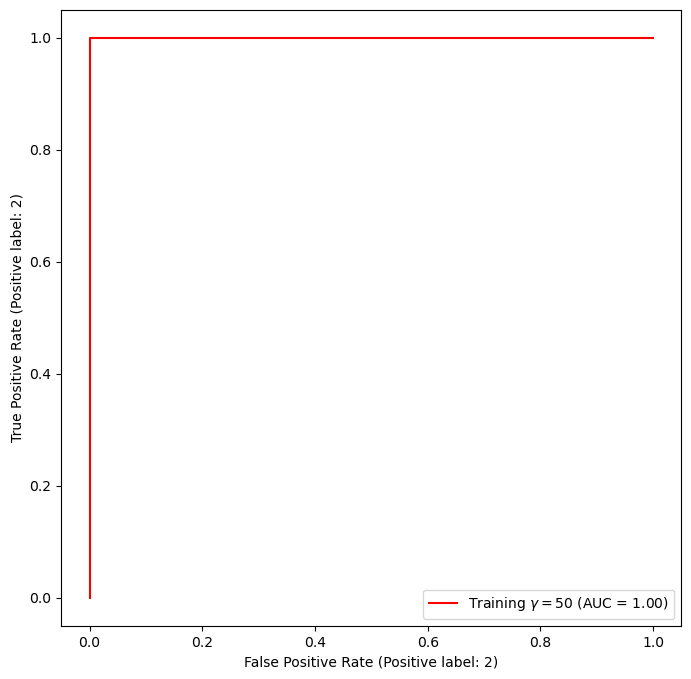

In [80]:
svm_flex = SVC(kernel='rbf', gamma=50, C=1)
svm_flex.fit(X_train, y_train)
fig, ax = subplots(figsize=(8, 8))
roc_curve(
    svm_flex,
    X_train,
    y_train,
    name='Training $\gamma=50$',
    color='r',
    ax=ax
);

How goes this model perform on the _test_ data?

In [83]:
roc_curve(svm_flex,
    X_test,
    y_test,
    name='Test $\gamma=50$',
    color='b',
    ax=ax
)
fig;

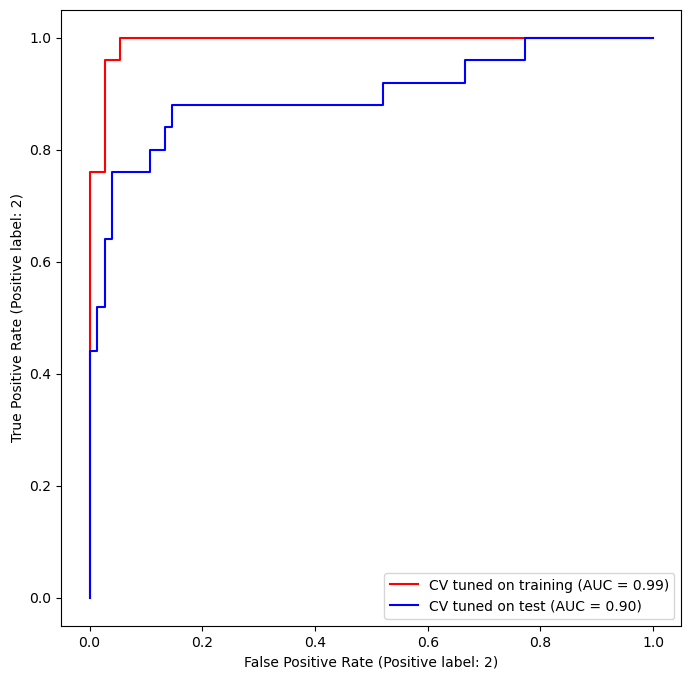

In [84]:
fig, ax = subplots(figsize=(8, 8))
for (X_, y_, c, name) in zip(
    (X_train, X_test),
    (y_train, y_test),
    ('r', 'b'),
    ('CV tuned on training',
     'CV tuned on test')
    ):
    roc_curve(
        best_svm,
        X_,
        y_,
        name=name,
        ax=ax,
        color=c
    )

### 5.6.4 SVM with Multiple Classes

When the response is a factor of more than two levels, `SVC()` will perform multi-class classification using the one-versus-one approach or the one-versus-rest approach, depending on whether the `decision_function_shape` parameter is set to `ovo` or `ovr`.

First, we generate a third class of observations:

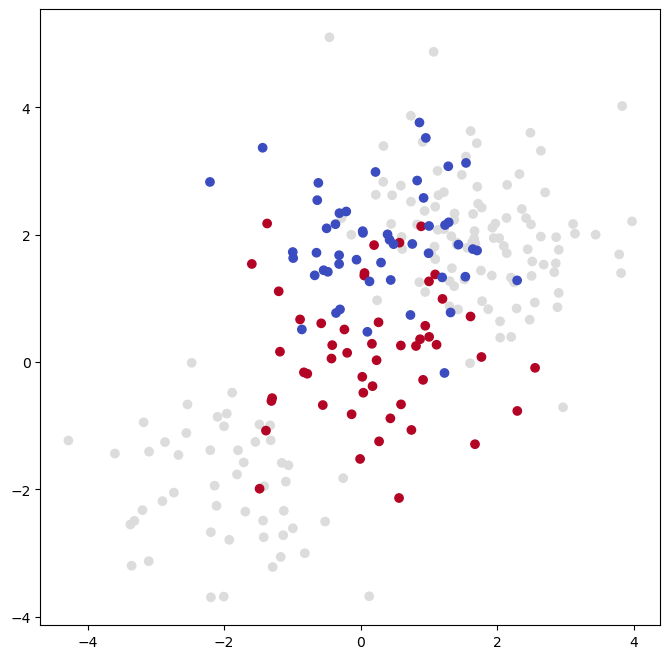

In [85]:
rng = np.random.default_rng(123)
X = np.vstack([X, rng.standard_normal((50, 2))])
y = np.hstack([y, [0]*50])
X[y==0, 1] += 2
fig, ax = subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.coolwarm);

We fit an SVM to the data using the one-versus-one approach:

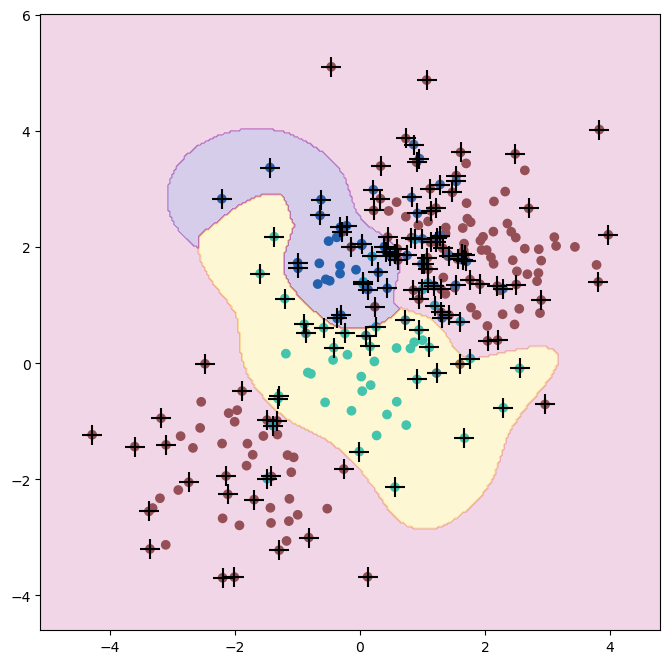

In [88]:
svm_rbf_3 = SVC(
    kernel='rbf',
    C=10,
    gamma=1,
    decision_function_shape='ovo'
)

svm_rbf_3.fit(X, y)

fig, ax = subplots(figsize=(8, 8))
plot_svm(
    X,
    y,
    svm_rbf_3,
    scatter_cmap=cm.tab10,
    ax=ax
)

### 9.6.5 Application to Gene Expression Data

We examine the `Khan`data set, consisting of a number of tissue samples corresponding to four distinct types of small round blue cell tumors. For each tissue sample, gene expression measurements are available. The data seet consists of training data, `xtrain` and `ytrain`, and test data, `xtest` and `ytest`.

In [89]:
Khan = load_data('Khan')
Khan['xtrain'].shape, Khan['xtest'].shape

((63, 2308), (20, 2308))

There is a very large number of features relative to the number of observations. This suggests that we should use a linear kernel because the additional flexibility that will result from using a polynomial or radial kernel is unnecessary.

In [92]:
khan_linear = SVC(kernel='linear', C=10)
khan_linear.fit(Khan['xtrain'], Khan['ytrain'])
confusion_table(khan_linear.predict(Khan['xtrain']), Khan['ytrain'])

Truth,1,2,3,4
Predicted,,,,
1,8,0,0,0
2,0,23,0,0
3,0,0,12,0
4,0,0,0,20


There are no training errors, but this isn't surprising: the large number of variables relative to the number of observations implies that it is easy to find hyperplanes that fully separate classes.

How does the model perform on the test data?

In [93]:
confusion_table(khan_linear.predict(Khan['xtest']), Khan['ytest'])

Truth,1,2,3,4
Predicted,,,,
1,3,0,0,0
2,0,6,2,0
3,0,0,4,0
4,0,0,0,5


We see that using `C=10` yields two test set errors on these data.